In [1]:
import numpy as np
import pandas as pd
import os
import tqdm
import torch

from itertools import chain

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_path = "/Users/sergmiller/Documents/my/IDAO-2021/data/idao_dataset/"

In [3]:
train_path = os.path.join(data_path, "train")

In [4]:
train_NR = os.path.join(train_path, "NR")
train_ER = os.path.join(train_path, "ER")

In [5]:
def read_all_png_in_dir(base_path : str, limit : int = None) -> dict:
    from os import listdir
    from os.path import isfile, join
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import tqdm
        
    imgs = [os.path.join(path, name) for path, subdirs, files in os.walk(base_path) for name in files]
    imgs = filter(lambda f: isfile(f) and '.png' == f[-4:], imgs)
    imgs = list(imgs)
    if limit is not None:
        imgs = imgs[:limit]
    data = {img : mpimg.imread(img) for img in tqdm.tqdm(imgs, position=0)}
    return data

In [6]:
sample_train_NR_imgs = read_all_png_in_dir(train_NR, 10)

100%|██████████| 10/10 [00:00<00:00, 126.07it/s]


In [7]:
sample_train_ER_imgs = read_all_png_in_dir(train_ER, 10)

100%|██████████| 10/10 [00:00<00:00, 104.54it/s]


In [8]:
list(sample_train_NR_imgs.keys())[0]

'/Users/sergmiller/Documents/my/IDAO-2021/data/idao_dataset/train/NR/-0.301800012588501__CYGNO_60_40_He_NR_1_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run3_ev372;1.png'

In [9]:
list(sample_train_ER_imgs.keys())[0]

'/Users/sergmiller/Documents/my/IDAO-2021/data/idao_dataset/train/ER/0.5023260116577148__CYGNO_60_40_ER_30_keV_930V_30cm_IDAO_iso_crop_hist_pic_run4_ev494;1.png'

In [10]:
list(sample_train_ER_imgs.values())[0].shape

(576, 576)

In [11]:
class LabeledDataset:
    def __init__(self):
        self.samples = []
        self.labels = []
        self.tags = []

    def add_sample(self, tag : str, sample : np.array, label : np.array):
        self.samples.append(sample)
        self.labels.append(label)
        self.tags.append(tag)
        
    def finalize(self):
        self.samples = np.array(self.samples)
        self.labels = np.array(self.labels)
        self.tags = np.array(self.tags)
        
    def save(self, file : str):
        np.savez_compressed(file, dataset=self)
        
    @staticmethod
    def load(file : str):
        return np.load(file, allow_pickle=True)['dataset'].item()

In [146]:
def process_sample(item):
    assert 2 == len(item)
 
    tag = item[0]
    sample = item[1]
    
    assert isinstance(sample, np.ndarray)
    assert (576, 576) == sample.shape
    
    sample = np.array(255 * sample, dtype=np.uint8)
    
    is_NR = tag.find('_NR_') != -1

    tag_parts = tag.split('_')
    kev_part_id = [i for i, part in enumerate(tag_parts) if part == 'keV']
    assert len(kev_part_id) == 1 and kev_part_id[0] > 0
    kev_part_id = kev_part_id[0]

    level = int(tag_parts[kev_part_id - 1])
    
    label = np.array(["NR" if is_NR else "ER", level])
    
    return tag, sample, label

def process_test_sample(item):
    assert 2 == len(item)
 
    tag = item[0]
    sample = item[1]
    
    assert isinstance(sample, np.ndarray)
    assert (576, 576) == sample.shape
    
    sample = np.array(255 * sample, dtype=np.uint8)
    
    return tag, sample, []

In [13]:
def build_particles_dataset(path : dir, process_sample=process_sample, limit : int = None) -> LabeledDataset:
    samples = read_all_png_in_dir(path, limit)
    d = LabeledDataset()
    for item in samples.items():
        tag, sample, label = process_sample(item)
        d.add_sample(tag, sample, label)
    d.finalize()
    return d

In [14]:
sample_dataset = build_particles_dataset(train_path, limit=10)

100%|██████████| 10/10 [00:00<00:00, 170.52it/s]


In [15]:
sample_dataset.samples.dtype

dtype('uint8')

In [16]:
sample_dataset.labels

array([['NR', '1'],
       ['NR', '6'],
       ['NR', '20'],
       ['NR', '1'],
       ['NR', '1'],
       ['NR', '6'],
       ['NR', '1'],
       ['NR', '20'],
       ['NR', '6'],
       ['NR', '1']], dtype='<U21')

['NR' '1']


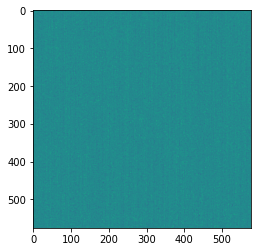

In [200]:
print(sample_dataset.labels[0])
plt.imshow(sample_dataset.samples[0])

['NR' '1']


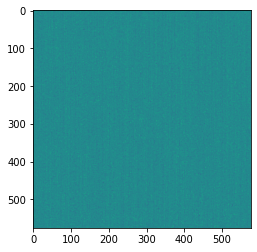

In [194]:
print(sample_dataset.labels[0])
plt.imshow(sample_dataset.samples[0])

['NR' '6']


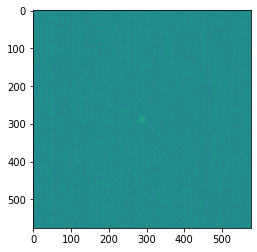

In [176]:
print(sample_dataset.labels[1])
plt.imshow(sample_dataset.samples[1])

['NR' '20']


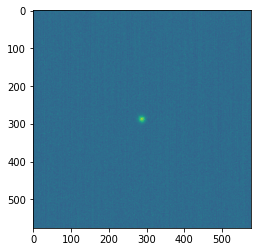

In [179]:
print(sample_dataset.labels[2])
plt.imshow(sample_dataset.samples[2])

In [241]:
sample_dataset.save('test.npz')
sample_dataset = LabeledDataset.load('test.npz')

In [244]:
sample_dataset.samples.shape

(10, 576, 576)

In [50]:
train_dataset = build_particles_dataset(train_path)

100%|██████████| 13404/13404 [01:44<00:00, 128.30it/s]


In [254]:
from collections import Counter

c = Counter([tuple(x) for x in train_dataset.labels])

In [255]:
c

Counter({('NR', '1'): 2177,
         ('NR', '6'): 2255,
         ('NR', '20'): 2208,
         ('NR', '3'): 2,
         ('NR', '30'): 2,
         ('NR', '10'): 2,
         ('ER', '30'): 2237,
         ('ER', '3'): 2243,
         ('ER', '10'): 2272,
         ('ER', '20'): 2,
         ('ER', '6'): 1,
         ('ER', '1'): 3})

In [262]:
!pip install torch torchvision

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [35]:
import torchvision.models as models
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
model = models.mobilenet_v3_small(pretrained=True)

In [28]:
import torch

In [29]:
torch.Tensor(10,2).repeat(2,0)

tensor([], size=(20, 0))

In [49]:
mobilenet_v3_small(torch.Tensor(2, 1, 500,500).repeat(1,3,1,1))

tensor([[1.9910, 1.9714, 1.0495,  ..., 0.5347, 2.2700, 3.0971],
        [2.2565, 2.0384, 1.3296,  ..., 0.4997, 1.6016, 3.3009]],
       grad_fn=<AddmmBackward>)

In [33]:
torch.set_num_threads(1)

In [34]:
torch.get_num_threads()

1

In [132]:
np.mean(np.mean(train_dataset.samples[:20], axis=2), axis=1)

array([100.37089482, 100.41410168, 100.47981469, 100.37365271,
       100.3844401 , 100.40769676, 100.41490946, 100.43469992,
       100.36840217, 100.3929368 , 100.39495624, 100.38473548,
       100.4410958 , 100.38902151, 100.46798141, 100.38144712,
       100.32607844, 100.41115994, 100.39048334, 100.39653863])

In [37]:
from joblib import Parallel, delayed

In [54]:
batch_size = 16
pretrained_embeds = []

model.train(False)

def f(i):
    batch = train_dataset.samples[i:i+batch_size]
    batch = torch.FloatTensor(batch.reshape(-1,1,576,576)).repeat(1,3,1,1) / 255
    with torch.no_grad():
        emb = model(batch).detach().numpy()
    assert emb.shape[0] > 0
    return emb


with Parallel(n_jobs=7) as parallel:
    pretrained_embeds = parallel(delayed(f)(i) for i in tqdm.tqdm(
        np.arange(0, train_dataset.samples.shape[0], batch_size), position=0))

100%|██████████| 838/838 [05:53<00:00,  2.37it/s]


In [55]:
pretrained_embeds_flat = []

for batch in pretrained_embeds:
    for x in batch:
        pretrained_embeds_flat.append(x)
        
pretrained_embeds = np.array(pretrained_embeds_flat).reshape(-1, 1000)

In [59]:
emb_dataset = LabeledDataset()
emb_dataset.samples = pretrained_embeds
emb_dataset.labels = train_dataset.labels
emb_dataset.tags = train_dataset.tags

In [60]:
emb_dataset.samples.shape

(13404, 1000)

In [61]:
emb_dataset.save('mobilenet_v3_small_embeddings.npz')

In [71]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

In [128]:
params = {
    "penalty": 'l1',
    "solver": 'saga',
    "verbose": 10,
    "max_iter": 100,
    "tol": 1e-5,
    "scoring" : 'roc_auc',
    "random_state": 0,
    "cv": 5,
    "n_jobs": 7
}

In [119]:
cv_label1 = LogisticRegressionCV(**params).fit(
    emb_dataset.samples, (emb_dataset.labels[:, 0] == 'NR').astype(int))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 1 seconds
max_iter reached after 7 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 13 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 10 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 10 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 8 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 8 seconds
convergence after 1 epochs took 0 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


convergence after 3 epochs took 1 seconds
max_iter reached after 7 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 13 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 10 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 10 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds
convergence after 1 epochs took 0 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


convergence after 3 epochs took 1 seconds
max_iter reached after 8 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 13 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 8 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 9 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 8 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.8min finished


max_iter reached after 12 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [124]:
np.mean(cv_label1.scores_[1], axis=0)

array([0.5       , 0.5       , 0.7952889 , 0.87402804, 0.94469283,
       0.95739159, 0.96157609, 0.96381906, 0.96529288, 0.96639186])

In [122]:
cv_label1.Cs_

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [114]:
cv_label1.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': 3,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 0,
 'refit': True,
 'scoring': 'roc_auc',
 'solver': 'saga',
 'tol': 1e-05,
 'verbose': 10}

In [143]:
import copy

classes = [1, 10, 20, 3, 30, 6]

def mae_scorer(estimator, X, y):
    y_pred = [int(_y) for _y in estimator.predict(X)]
    y_pred = np.array(y_pred)
    y = np.array([classes[_y] for _y in y])
    return np.mean(np.abs(y_pred - y))

params2 = copy.copy(params)
params2['scoring'] = mae_scorer
params2['class_weight'] = {str(c) : c for c in classes}
cv_label2 = LogisticRegressionCV(**params2).fit(
    emb_dataset.samples, emb_dataset.labels[:, 1])

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.


max_iter reached after 46 seconds
max_iter reached after 46 seconds
max_iter reached after 46 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 46 seconds
max_iter reached after 46 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 49 seconds
max_iter reached after 49 seconds
max_iter reached after 49 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 49 seconds
max_iter reached after 49 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 56 seconds
max_iter reached after 56 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 56 seconds
max_iter reached after 56 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 56 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 75 seconds
max_iter reached after 75 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 76 seconds
max_iter reached after 76 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 76 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 76 seconds
max_iter reached after 76 seconds
max_iter reached after 75 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 75 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 75 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 69 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 69 seconds
max_iter reached after 69 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 70 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 70 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 74 seconds
max_iter reached after 74 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 74 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 75 seconds
max_iter reached after 76 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 71 seconds
max_iter reached after 71 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 71 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 71 seconds
max_iter reached after 71 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 65 seconds
max_iter reached after 65 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 65 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 64 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 65 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 66 seconds
max_iter reached after 66 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   2 out of   5 | elapsed: 10.8min remaining: 16.2min
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 66 seconds


[Parallel(n_jobs=7)]: Done   3 out of   5 | elapsed: 10.8min remaining:  7.2min


max_iter reached after 66 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 66 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=7)]: Done   5 out of   5 | elapsed: 10.8min remaining:    0.0s
[Parallel(n_jobs=7)]: Done   5 out of   5 | elapsed: 10.8min finished


max_iter reached after 58 seconds


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [142]:
np.mean(cv_label2.scores_['1'],axis=0) # not weighted

array([10.68017027, 10.68017027, 10.09729052,  9.80483741,  9.63690119,
        9.57527796,  9.54491318,  9.53208126,  9.52514296,  9.51149031])

In [144]:
np.mean(cv_label2.scores_['1'],axis=0) # weighted

array([ 9.59965186,  9.4570564 ,  9.96051226, 10.08321655,  9.88160343,
        9.84861552,  9.80512292,  9.85751204,  9.71321238,  9.77365697])

In [148]:
pub_test_dataset = build_particles_dataset(
    os.path.join(data_path, "public_test"),
    process_sample=process_test_sample)

100%|██████████| 1502/1502 [00:08<00:00, 170.08it/s]


In [149]:
private_test_dataset = build_particles_dataset(
    os.path.join(data_path, "private_test"),
    process_sample=process_test_sample)

100%|██████████| 15062/15062 [02:01<00:00, 124.34it/s]


In [162]:
def build_embd_dataset(d : LabeledDataset) -> LabeledDataset:
    batch_size = 16
    pretrained_embeds = []

    model.train(False)

    def f(i):
        batch = d.samples[i:i+batch_size]
        batch = torch.FloatTensor(batch.reshape(-1,1,576,576)).repeat(1,3,1,1) / 255
        with torch.no_grad():
            emb = model(batch).detach().numpy()
        assert emb.shape[0] > 0
        return emb


    with Parallel(n_jobs=7) as parallel:
        pretrained_embeds = parallel(delayed(f)(i) for i in tqdm.tqdm(
            np.arange(0, d.samples.shape[0], batch_size), position=0))
    
    pretrained_embeds_flat = []

    for batch in pretrained_embeds:
        for x in batch:
            pretrained_embeds_flat.append(x)

    pretrained_embeds = np.array(pretrained_embeds_flat).reshape(-1, 1000)
    
    
    emb_dataset = LabeledDataset()
    emb_dataset.samples = pretrained_embeds
    emb_dataset.labels = train_dataset.labels
    emb_dataset.tags = train_dataset.tags
    
    return emb_dataset


def apply_all_models_to_test_dataset(
    d : LabeledDataset,
    key : str,
    _emb_cache={}
) -> LabeledDataset:
    if key not in _emb_cache:
        _emb_cache[key] = build_embd_dataset(d)
    emb_dataset = _emb_cache.get(key)

    labels1 = cv_label1.predict(emb_dataset.samples)
    labels2 = cv_label2.predict(emb_dataset.samples)
    
    labels = np.stack([labels1, labels2]).T
    
    emb_dataset.labels = labels
    
    return emb_dataset

In [163]:
sample_res = apply_all_models_to_test_dataset(sample_dataset, 'sample')

100%|██████████| 1/1 [00:00<00:00, 4032.98it/s]


In [166]:
pub_test_predictions = apply_all_models_to_test_dataset(pub_test_dataset, 'pub_test')

100%|██████████| 94/94 [00:28<00:00,  3.28it/s]


In [ ]:
private_test_predictions = apply_all_models_to_test_dataset(
    private_test_dataset, 'private_test')

 81%|████████  | 763/942 [05:06<01:13,  2.43it/s]

In [ ]:
def dataset2submit_csv(d : LabeledDataset, fname : str):
    pred = np.stack([d.tags, d.labels[:, 0], d.labels[:, 1]]).T
    data_frame = pd.DataFrame(
        pred,
        columns=["id", "classification_predictions", "regression_predictions"])
    data_frame.to_csv(fname, index=False, header=True)